In [67]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import glob
from collections import defaultdict
from pathlib import Path
import numpy as np
import csv
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:e}'.format)
#from lmfit.models import QuadraticModel, LorentzianModel

In [10]:
parent_dir = '/home/sethshj/Programs/Cr_data/13NOV24'


In [18]:
transition_metals = [
    'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn'
]

matching_files = []

# Loop through each transition metal and search for files that match the pattern
for metal in transition_metals:
    # Use glob to search for files where the transition metal appears after the underscore
    pattern = f'{parent_dir}/**/**_Cr/Corvus.cfavg.xes.out'
    matching_files.extend(glob.glob(pattern, recursive=True))

print('This is the file tree you are trying to print out: ', pattern)
print('These are the matching_files to your query: ', matching_files)

This is the file tree you are trying to print out:  /home/sethshj/Programs/Cr_data/13NOV24/**/**_Cr/Corvus.cfavg.xes.out
These are the matching_files to your query:  ['/home/sethshj/Programs/Cr_data/13NOV24/mp-1007974/mp-1007974_Cr/Corvus.cfavg.xes.out', '/home/sethshj/Programs/Cr_data/13NOV24/mp-1008280/mp-1008280_Cr/Corvus.cfavg.xes.out', '/home/sethshj/Programs/Cr_data/13NOV24/mp-1009079/mp-1009079_Cr/Corvus.cfavg.xes.out', '/home/sethshj/Programs/Cr_data/13NOV24/mp-1009485/mp-1009485_Cr/Corvus.cfavg.xes.out', '/home/sethshj/Programs/Cr_data/13NOV24/mp-1009592/mp-1009592_Cr/Corvus.cfavg.xes.out', '/home/sethshj/Programs/Cr_data/13NOV24/mp-1010071/mp-1010071_Cr/Corvus.cfavg.xes.out', '/home/sethshj/Programs/Cr_data/13NOV24/mp-1014993/mp-1014993_Cr/Corvus.cfavg.xes.out', '/home/sethshj/Programs/Cr_data/13NOV24/mp-1014995/mp-1014995_Cr/Corvus.cfavg.xes.out', '/home/sethshj/Programs/Cr_data/13NOV24/mp-1016059/mp-1016059_Cr/Corvus.cfavg.xes.out', '/home/sethshj/Programs/Cr_data/13NOV24/m

# Initial Examinations
### 1. Visually inspect the data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1007974/mp-1007974_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.969147e+03    3.484278e-05    3.484278e-05    3.484278e-05 3.484278e-05
1 5.969247e+03    3.239936e-05    3.239936e-05    3.239936e-05 3.239936e-05
2 5.969347e+03    3.006054e-05    3.006054e-05    3.006054e-05 3.006054e-05
3 5.969447e+03    2.783146e-05    2.783146e-05    2.783146e-05 2.783146e-05
4 5.969547e+03    2.577586e-05    2.577586e-05    2.577586e-05 2.577586e-05
0   3.484278e-05
1   3.239936e-05
2   3.006054e-05
3   2.783146e-05
4   2.577586e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1007974/mp-1007974_Cr/Corvus.cfavg.xes.out: 'Series' object is no

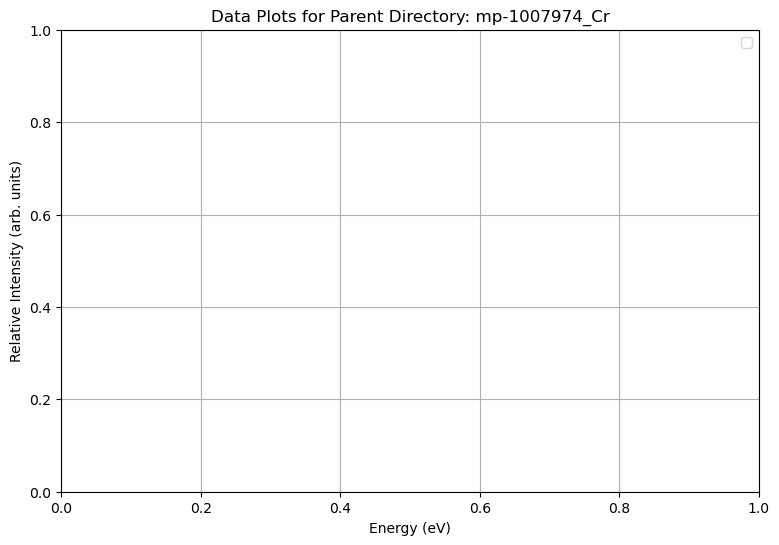

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1008280/mp-1008280_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.969550e+03    3.494900e-05    3.494895e-05    3.494890e-05 3.494895e-05
1 5.969650e+03    3.245998e-05    3.245994e-05    3.245990e-05 3.245994e-05
2 5.969750e+03    3.008930e-05    3.008926e-05    3.008922e-05 3.008926e-05
3 5.969850e+03    2.789057e-05    2.789053e-05    2.789050e-05 2.789054e-05
4 5.969950e+03    2.581095e-05    2.581091e-05    2.581088e-05 2.581091e-05
0   3.494900e-05
1   3.245998e-05
2   3.008930e-05
3   2.789057e-05
4   2.581095e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1008280/mp-1008280_Cr/Corvus.cfavg.xes.out: 'Series' object is no

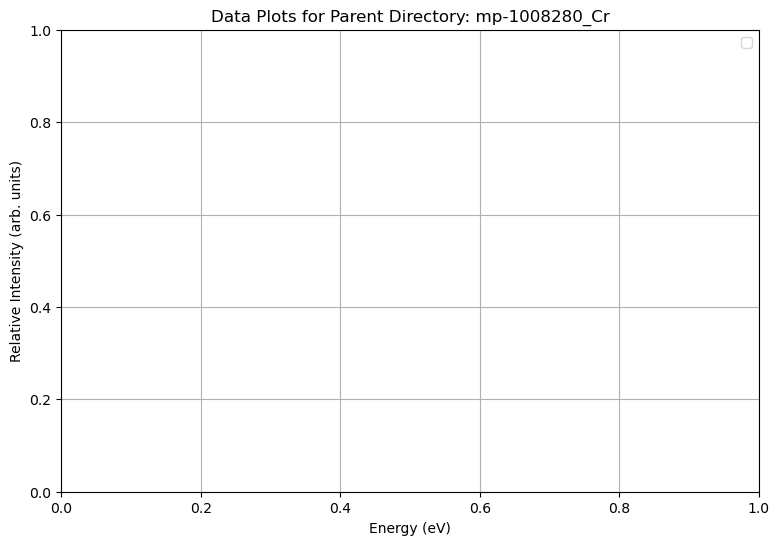

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1009079/mp-1009079_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.963544e+03    3.593145e-05    3.593145e-05    3.593145e-05 3.593145e-05
1 5.963644e+03    3.338482e-05    3.338482e-05    3.338482e-05 3.338482e-05
2 5.963744e+03    3.098666e-05    3.098666e-05    3.098666e-05 3.098666e-05
3 5.963844e+03    2.868207e-05    2.868207e-05    2.868207e-05 2.868207e-05
4 5.963944e+03    2.652719e-05    2.652719e-05    2.652719e-05 2.652719e-05
0   3.593145e-05
1   3.338482e-05
2   3.098666e-05
3   2.868207e-05
4   2.652719e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1009079/mp-1009079_Cr/Corvus.cfavg.xes.out: 'Series' object is no

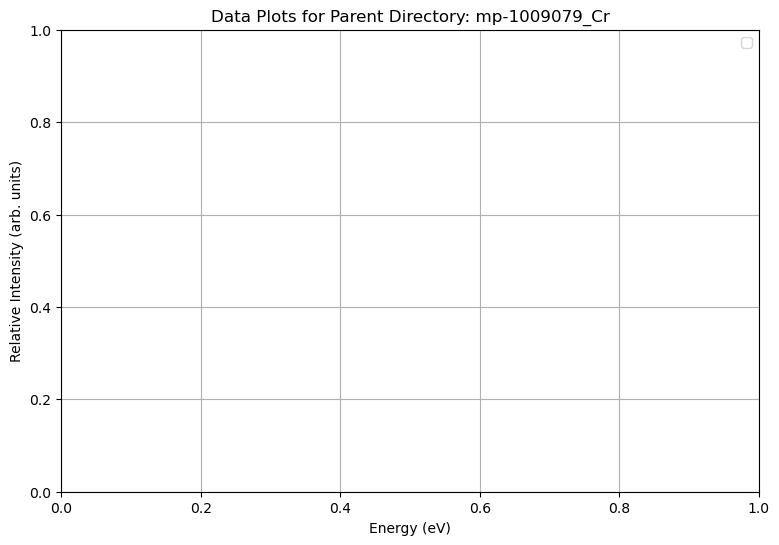

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1009485/mp-1009485_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.967702e+03    3.092191e-05    3.092191e-05    3.092191e-05 3.092191e-05
1 5.967802e+03    2.884544e-05    2.884544e-05    2.884544e-05 2.884544e-05
2 5.967902e+03    2.683098e-05    2.683098e-05    2.683099e-05 2.683098e-05
3 5.968002e+03    2.492016e-05    2.492016e-05    2.492016e-05 2.492016e-05
4 5.968102e+03    2.315341e-05    2.315341e-05    2.315340e-05 2.315340e-05
0   3.092191e-05
1   2.884544e-05
2   2.683098e-05
3   2.492016e-05
4   2.315341e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1009485/mp-1009485_Cr/Corvus.cfavg.xes.out: 'Series' object is no

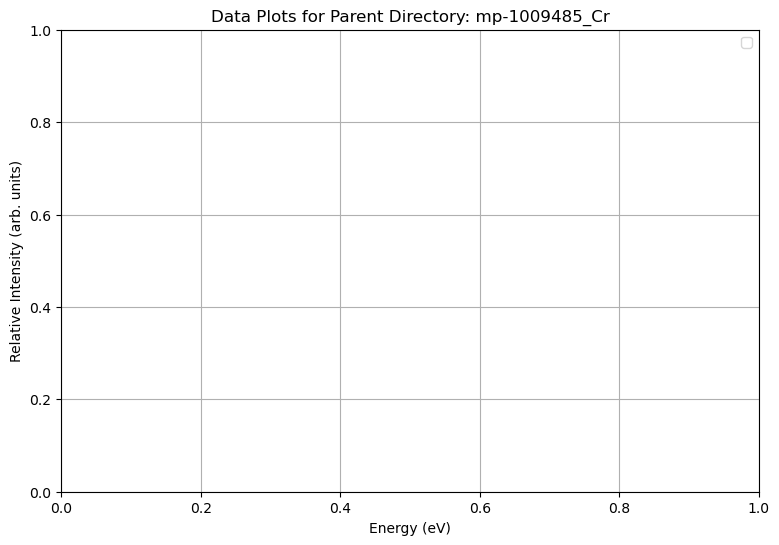

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1009592/mp-1009592_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.965397e+03    3.398604e-05    3.398604e-05    3.398604e-05 3.398604e-05
1 5.965497e+03    3.160212e-05    3.160212e-05    3.160212e-05 3.160212e-05
2 5.965597e+03    2.931642e-05    2.931642e-05    2.931642e-05 2.931642e-05
3 5.965697e+03    2.713083e-05    2.713083e-05    2.713083e-05 2.713083e-05
4 5.965797e+03    2.509543e-05    2.509543e-05    2.509543e-05 2.509543e-05
0   3.398604e-05
1   3.160212e-05
2   2.931642e-05
3   2.713083e-05
4   2.509543e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1009592/mp-1009592_Cr/Corvus.cfavg.xes.out: 'Series' object is no

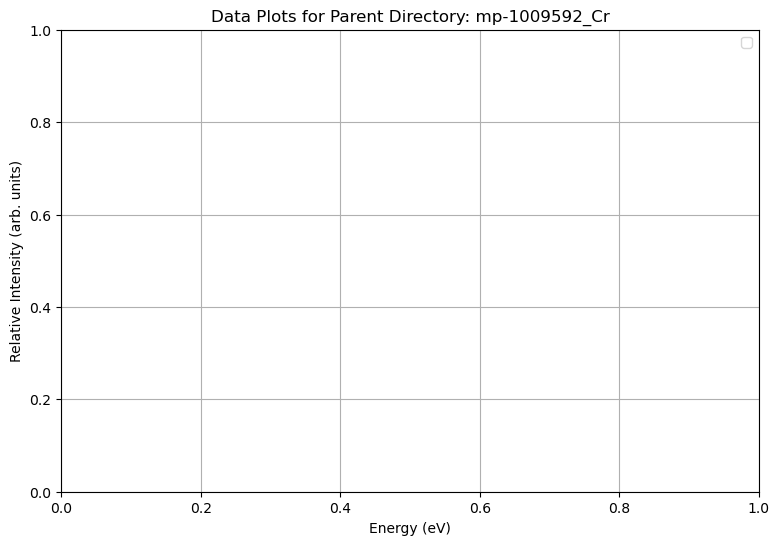

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1010071/mp-1010071_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.969441e+03    3.492475e-05    3.492475e-05    3.492475e-05 3.492475e-05
1 5.969541e+03    3.243734e-05    3.243734e-05    3.243734e-05 3.243734e-05
2 5.969641e+03    3.006952e-05    3.006952e-05    3.006952e-05 3.006952e-05
3 5.969741e+03    2.787436e-05    2.787436e-05    2.787436e-05 2.787436e-05
4 5.969841e+03    2.579957e-05    2.579957e-05    2.579957e-05 2.579957e-05
0   3.492475e-05
1   3.243734e-05
2   3.006952e-05
3   2.787436e-05
4   2.579957e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1010071/mp-1010071_Cr/Corvus.cfavg.xes.out: 'Series' object is no

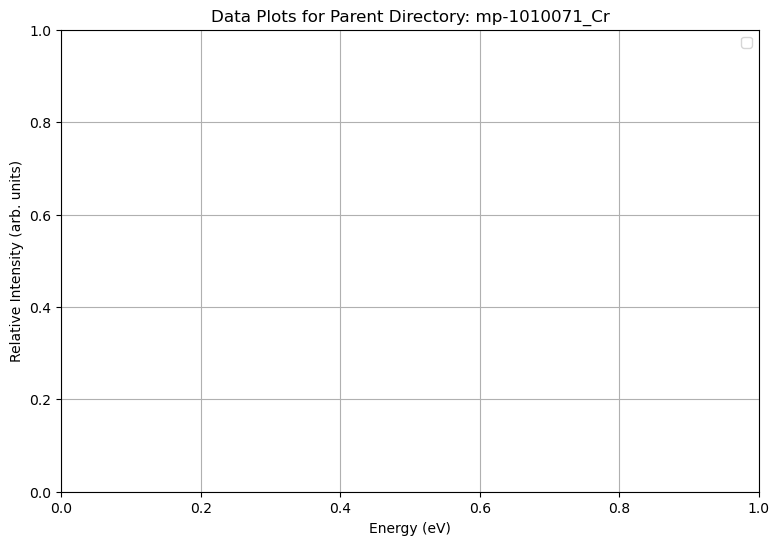

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1014993/mp-1014993_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.964540e+03    3.476790e-05    3.476789e-05    3.476789e-05 3.476789e-05
1 5.964640e+03    3.237022e-05    3.237023e-05    3.237022e-05 3.237022e-05
2 5.964740e+03    3.005672e-05    3.005673e-05    3.005672e-05 3.005672e-05
3 5.964840e+03    2.788852e-05    2.788852e-05    2.788852e-05 2.788852e-05
4 5.964940e+03    2.587250e-05    2.587250e-05    2.587250e-05 2.587250e-05
0   3.476790e-05
1   3.237022e-05
2   3.005672e-05
3   2.788852e-05
4   2.587250e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1014993/mp-1014993_Cr/Corvus.cfavg.xes.out: 'Series' object is no

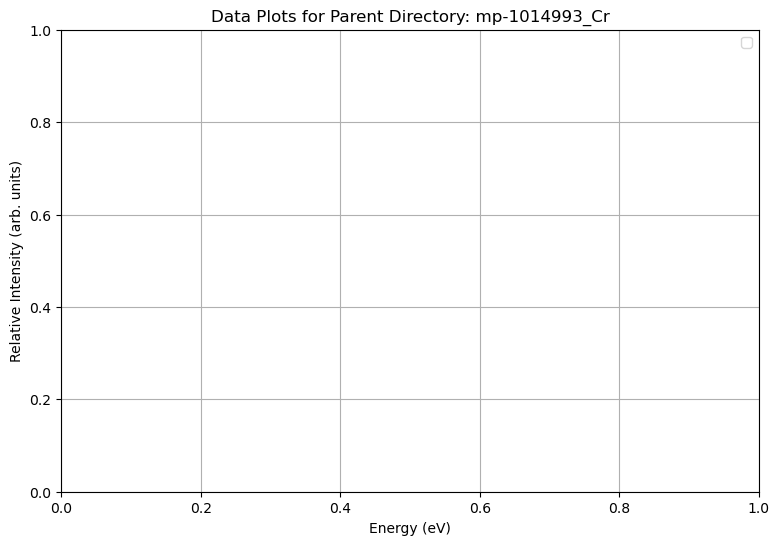

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1014995/mp-1014995_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.963903e+03    3.319972e-05    3.318442e-05    3.319375e-05 3.319263e-05
1 5.964003e+03    3.097756e-05    3.095893e-05    3.097117e-05 3.096922e-05
2 5.964103e+03    2.878484e-05    2.876317e-05    2.877809e-05 2.877537e-05
3 5.964203e+03    2.675297e-05    2.672837e-05    2.674587e-05 2.674240e-05
4 5.964303e+03    2.483509e-05    2.480779e-05    2.482766e-05 2.482351e-05
0   3.319972e-05
1   3.097756e-05
2   2.878484e-05
3   2.675297e-05
4   2.483509e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1014995/mp-1014995_Cr/Corvus.cfavg.xes.out: 'Series' object is no

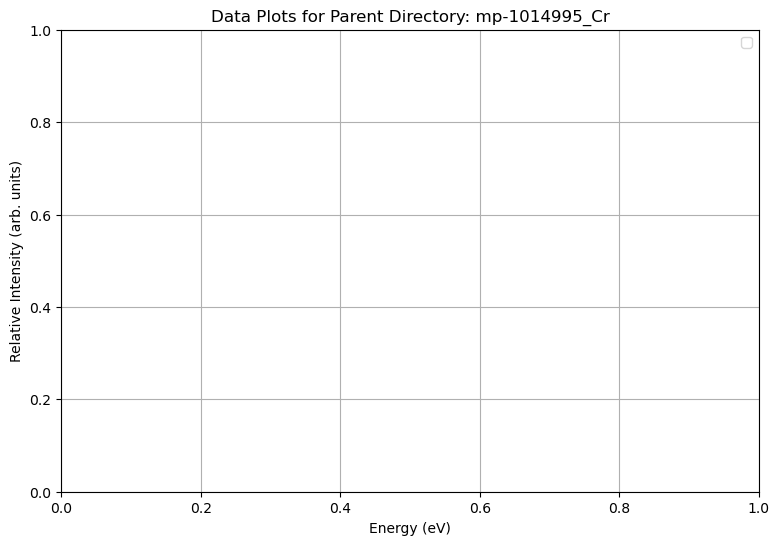

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1016059/mp-1016059_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.963963e+03    3.301477e-05    3.300132e-05    3.300709e-05 3.300773e-05
1 5.964063e+03    3.077804e-05    3.076551e-05    3.077243e-05 3.077199e-05
2 5.964163e+03    2.861625e-05    2.860460e-05    2.861259e-05 2.861115e-05
3 5.964263e+03    2.658821e-05    2.657736e-05    2.658634e-05 2.658397e-05
4 5.964363e+03    2.469858e-05    2.468849e-05    2.469841e-05 2.469516e-05
0   3.301477e-05
1   3.077804e-05
2   2.861625e-05
3   2.658821e-05
4   2.469858e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1016059/mp-1016059_Cr/Corvus.cfavg.xes.out: 'Series' object is no

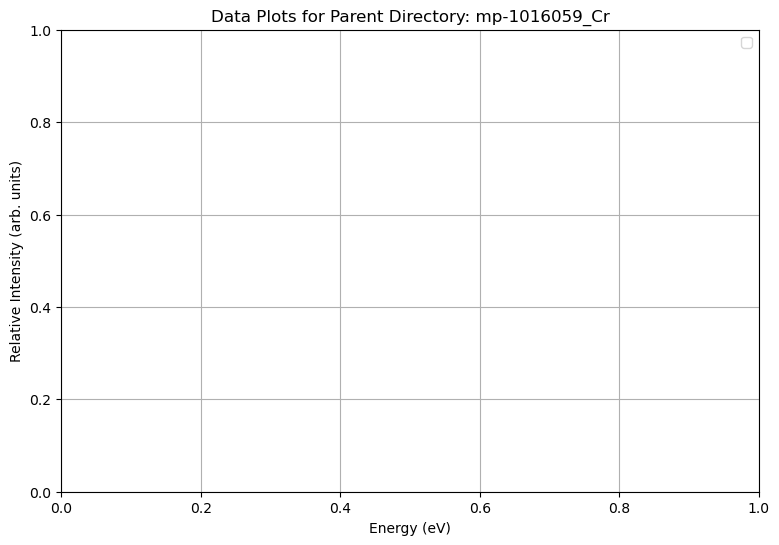

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1016225/mp-1016225_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.965332e+03    3.952679e-05    3.946186e-05    3.945886e-05 3.948250e-05
1 5.965432e+03    3.668346e-05    3.661798e-05    3.661493e-05 3.663879e-05
2 5.965532e+03    3.396975e-05    3.390374e-05    3.390064e-05 3.392471e-05
3 5.965632e+03    3.141083e-05    3.134429e-05    3.134113e-05 3.136542e-05
4 5.965732e+03    2.902558e-05    2.895850e-05    2.895529e-05 2.897979e-05
0   3.952679e-05
1   3.668346e-05
2   3.396975e-05
3   3.141083e-05
4   2.902558e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1016225/mp-1016225_Cr/Corvus.cfavg.xes.out: 'Series' object is no

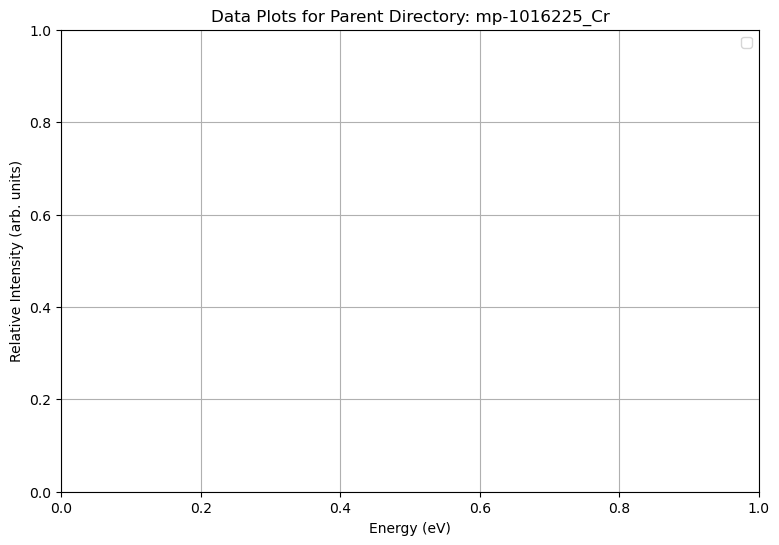

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1016300/mp-1016300_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.964741e+03    3.958000e-05    3.955834e-05    3.956544e-05 3.956793e-05
1 5.964841e+03    3.670124e-05    3.667945e-05    3.668662e-05 3.668911e-05
2 5.964941e+03    3.400171e-05    3.397978e-05    3.398702e-05 3.398950e-05
3 5.965041e+03    3.144062e-05    3.141855e-05    3.142586e-05 3.142834e-05
4 5.965141e+03    2.903841e-05    2.901620e-05    2.902358e-05 2.902607e-05
0   3.958000e-05
1   3.670124e-05
2   3.400171e-05
3   3.144062e-05
4   2.903841e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1016300/mp-1016300_Cr/Corvus.cfavg.xes.out: 'Series' object is no

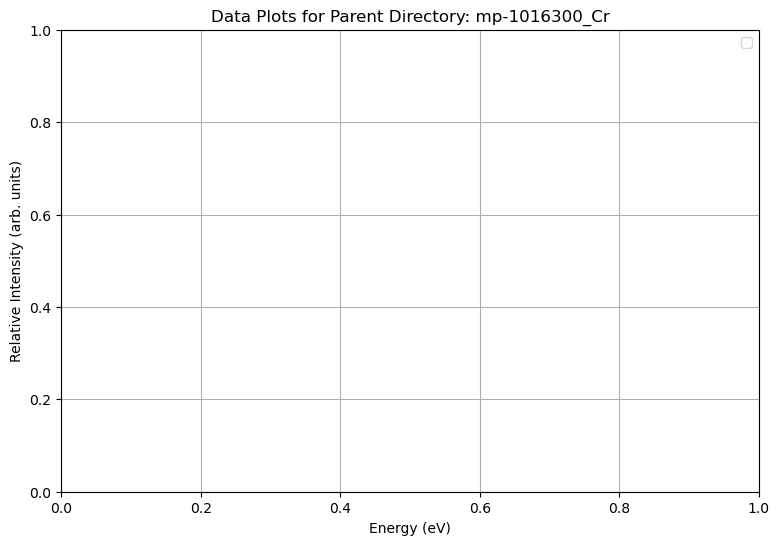

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1016625/mp-1016625_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.965024e+03    3.977548e-05    4.148632e-05    3.977005e-05 4.034395e-05
1 5.965124e+03    3.693873e-05    3.832592e-05    3.693318e-05 3.739928e-05
2 5.965224e+03    3.420934e-05    3.533994e-05    3.420368e-05 3.458432e-05
3 5.965324e+03    3.162773e-05    3.255795e-05    3.162198e-05 3.193589e-05
4 5.965424e+03    2.923318e-05    3.000710e-05    2.922733e-05 2.948920e-05
0   3.977548e-05
1   3.693873e-05
2   3.420934e-05
3   3.162773e-05
4   2.923318e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1016625/mp-1016625_Cr/Corvus.cfavg.xes.out: 'Series' object is no

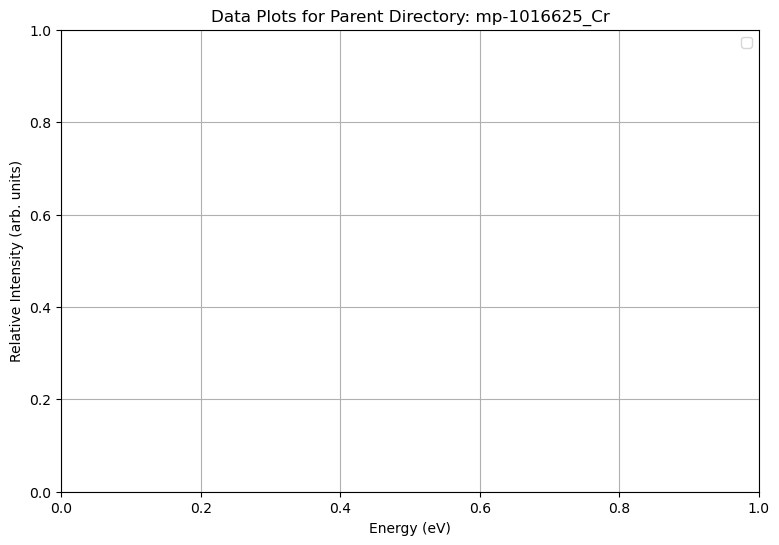

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1016653/mp-1016653_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.965307e+03    3.803682e-05    3.816998e-05    3.803216e-05 3.807965e-05
1 5.965407e+03    3.534702e-05    3.547966e-05    3.534223e-05 3.538964e-05
2 5.965507e+03    3.274925e-05    3.288148e-05    3.274434e-05 3.279169e-05
3 5.965607e+03    3.027147e-05    3.040342e-05    3.026645e-05 3.031378e-05
4 5.965707e+03    2.799015e-05    2.812194e-05    2.798503e-05 2.803237e-05
0   3.803682e-05
1   3.534702e-05
2   3.274925e-05
3   3.027147e-05
4   2.799015e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1016653/mp-1016653_Cr/Corvus.cfavg.xes.out: 'Series' object is no

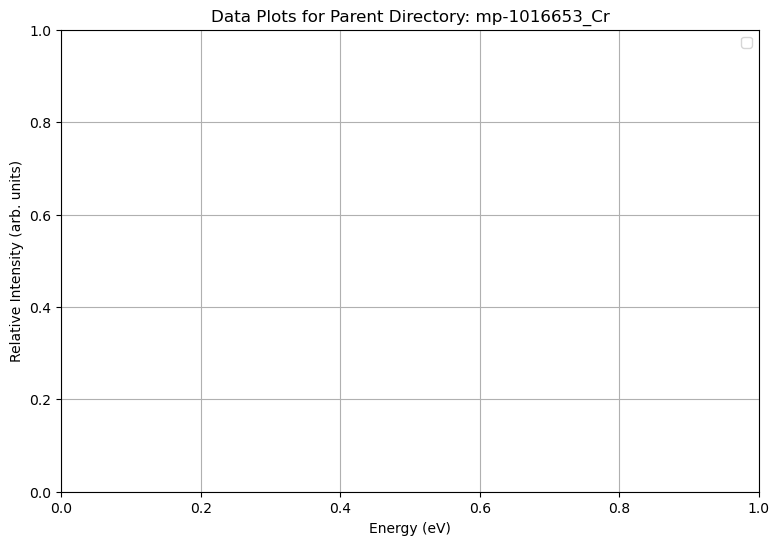

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1016677/mp-1016677_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.966298e+03    3.640415e-05    3.646084e-05    3.644020e-05 3.643507e-05
1 5.966398e+03    3.380909e-05    3.380146e-05    3.381215e-05 3.380757e-05
2 5.966498e+03    3.132632e-05    3.125808e-05    3.129829e-05 3.129423e-05
3 5.966598e+03    2.897471e-05    2.884967e-05    2.891755e-05 2.891398e-05
4 5.966698e+03    2.677039e-05    2.659242e-05    2.668610e-05 2.668297e-05
0   3.640415e-05
1   3.380909e-05
2   3.132632e-05
3   2.897471e-05
4   2.677039e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1016677/mp-1016677_Cr/Corvus.cfavg.xes.out: 'Series' object is no

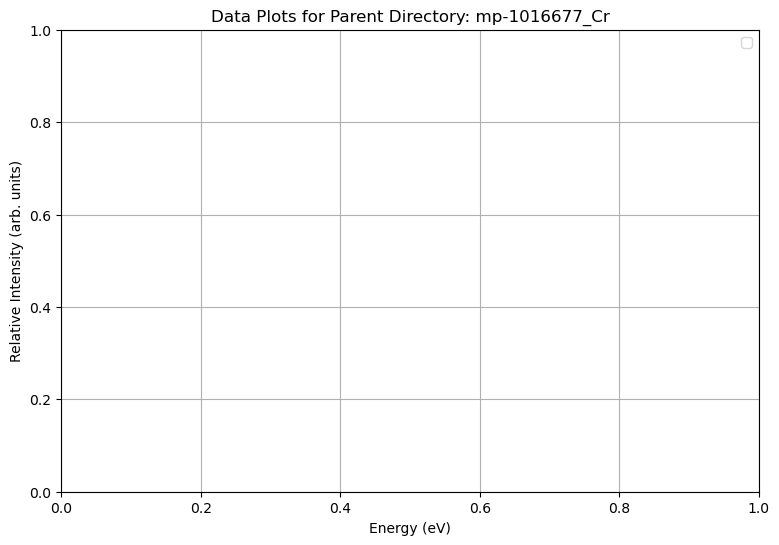

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1017080/mp-1017080_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.964899e+03    3.956025e-05    3.956403e-05    3.954398e-05 3.955609e-05
1 5.964999e+03    3.668017e-05    3.668410e-05    3.666434e-05 3.667620e-05
2 5.965099e+03    3.397745e-05    3.398152e-05    3.396202e-05 3.397366e-05
3 5.965199e+03    3.141392e-05    3.141812e-05    3.139886e-05 3.141030e-05
4 5.965299e+03    2.900615e-05    2.901048e-05    2.899143e-05 2.900269e-05
0   3.956025e-05
1   3.668017e-05
2   3.397745e-05
3   3.141392e-05
4   2.900615e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1017080/mp-1017080_Cr/Corvus.cfavg.xes.out: 'Series' object is no

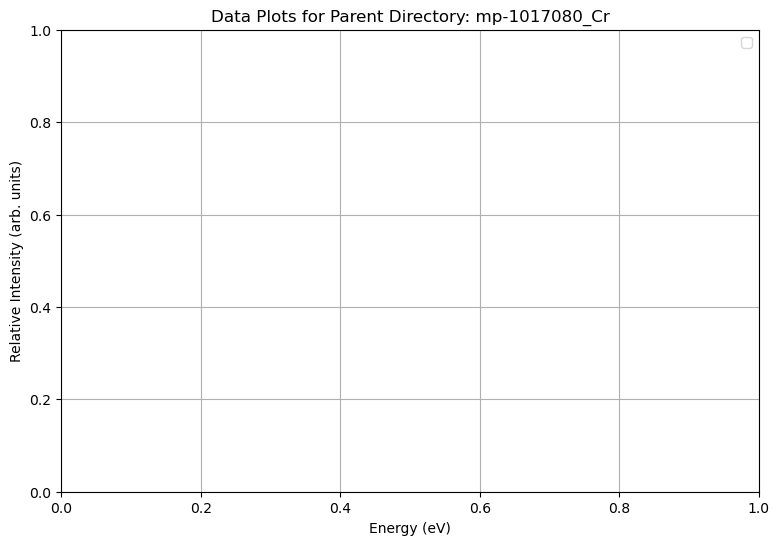

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1017099/mp-1017099_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.964817e+03    3.939619e-05    3.934725e-05    3.938647e-05 3.937664e-05
1 5.964917e+03    3.659660e-05    3.654745e-05    3.658677e-05 3.657694e-05
2 5.965017e+03    3.391469e-05    3.386532e-05    3.390474e-05 3.389492e-05
3 5.965117e+03    3.133328e-05    3.128370e-05    3.132322e-05 3.131340e-05
4 5.965217e+03    2.892685e-05    2.887705e-05    2.891668e-05 2.890686e-05
0   3.939619e-05
1   3.659660e-05
2   3.391469e-05
3   3.133328e-05
4   2.892685e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1017099/mp-1017099_Cr/Corvus.cfavg.xes.out: 'Series' object is no

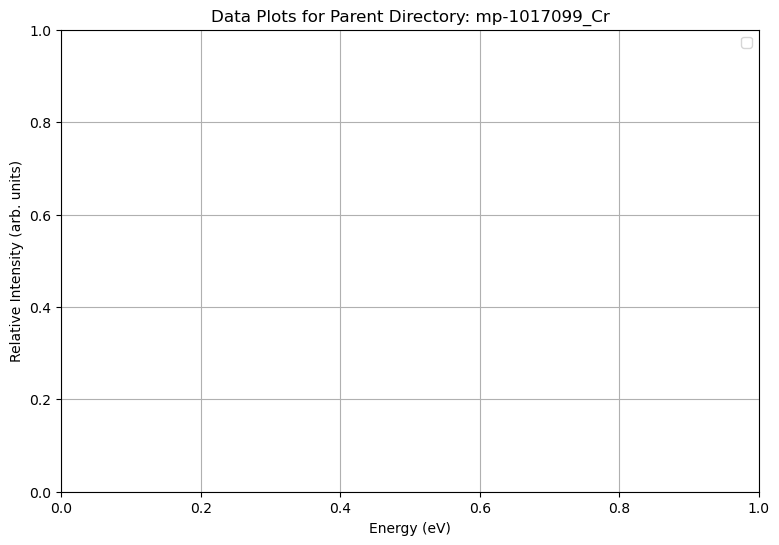

This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1017197/mp-1017197_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.964804e+03    3.954529e-05    3.953677e-05    3.952894e-05 3.953700e-05
1 5.964904e+03    3.671814e-05    3.670930e-05    3.670206e-05 3.670983e-05
2 5.965004e+03    3.397973e-05    3.397053e-05    3.396389e-05 3.397138e-05
3 5.965104e+03    3.142680e-05    3.141718e-05    3.141116e-05 3.141838e-05
4 5.965204e+03    2.903948e-05    2.902937e-05    2.902401e-05 2.903095e-05
0   3.954529e-05
1   3.671814e-05
2   3.397973e-05
3   3.142680e-05
4   2.903948e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1017197/mp-1017197_Cr/Corvus.cfavg.xes.out: 'Series' object is no

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


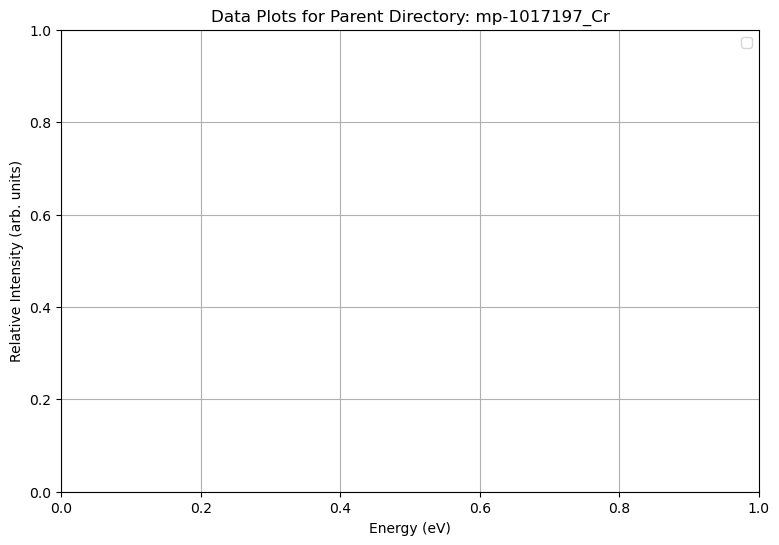

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1017317/mp-1017317_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.964782e+03    3.954818e-05    3.955294e-05    3.954647e-05 3.954920e-05
1 5.964882e+03    3.667203e-05    3.667681e-05    3.667026e-05 3.667303e-05
2 5.964982e+03    3.397485e-05    3.397964e-05    3.397302e-05 3.397584e-05
3 5.965082e+03    3.141827e-05    3.142308e-05    3.141639e-05 3.141924e-05
4 5.965182e+03    2.902038e-05    2.902519e-05    2.901844e-05 2.902134e-05
0   3.954818e-05
1   3.667203e-05
2   3.397485e-05
3   3.141827e-05
4   2.902038e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1017317/mp-1017317_Cr/Corvus.cfavg.xes.out: 'Series' object is no

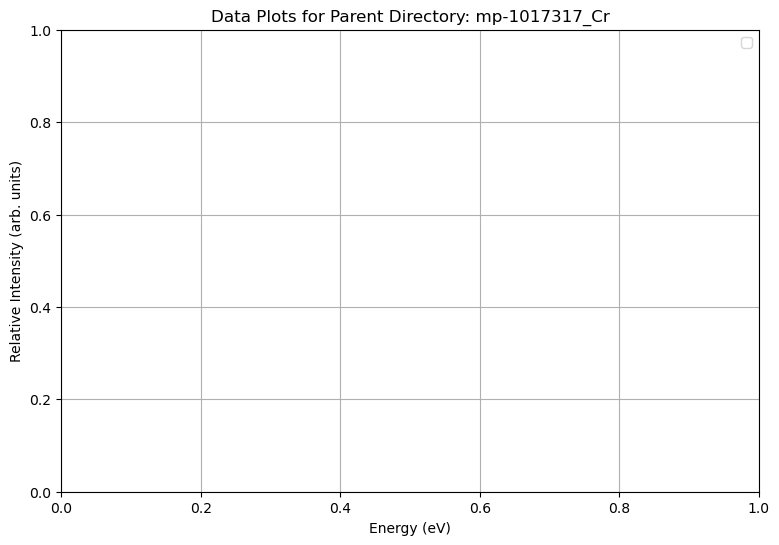

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1018066/mp-1018066_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.964407e+03    3.538667e-05    3.538545e-05    3.538059e-05 3.538424e-05
1 5.964507e+03    3.289825e-05    3.289696e-05    3.289176e-05 3.289566e-05
2 5.964607e+03    3.052083e-05    3.051945e-05    3.051394e-05 3.051807e-05
3 5.964707e+03    2.827141e-05    2.826996e-05    2.826414e-05 2.826850e-05
4 5.964807e+03    2.616223e-05    2.616070e-05    2.615459e-05 2.615917e-05
0   3.538667e-05
1   3.289825e-05
2   3.052083e-05
3   2.827141e-05
4   2.616223e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1018066/mp-1018066_Cr/Corvus.cfavg.xes.out: 'Series' object is no

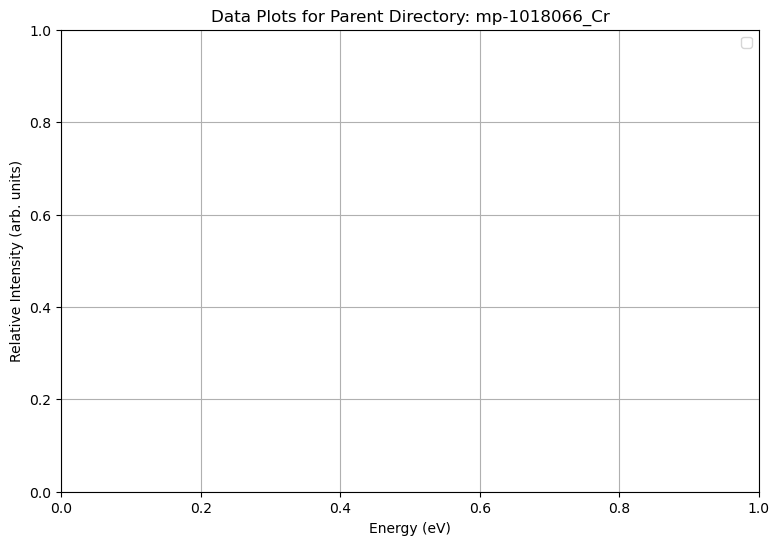

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


This is the data I am seeing from reading the file into a Pandas Dataframe:  /home/sethshj/Programs/Cr_data/13NOV24/mp-1018079/mp-1018079_Cr/Corvus.cfavg.xes.out
These are the column names:  Index(['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic'], dtype='object')
        Energy  x_polarization  y_polarization  z_polarization    Isotropic
0 5.963637e+03    3.505463e-05    3.505463e-05    3.506323e-05 3.505750e-05
1 5.963737e+03    3.254536e-05    3.254536e-05    3.255350e-05 3.254808e-05
2 5.963837e+03    3.018758e-05    3.018758e-05    3.019528e-05 3.019014e-05
3 5.963937e+03    2.792399e-05    2.792399e-05    2.793128e-05 2.792642e-05
4 5.964037e+03    2.580625e-05    2.580625e-05    2.581318e-05 2.580856e-05
0   3.505463e-05
1   3.254536e-05
2   3.018758e-05
3   2.792399e-05
4   2.580625e-05
Name: x_polarization, dtype: float64
(351, 5)
Error reading /home/sethshj/Programs/Cr_data/13NOV24/mp-1018079/mp-1018079_Cr/Corvus.cfavg.xes.out: 'Series' object is no

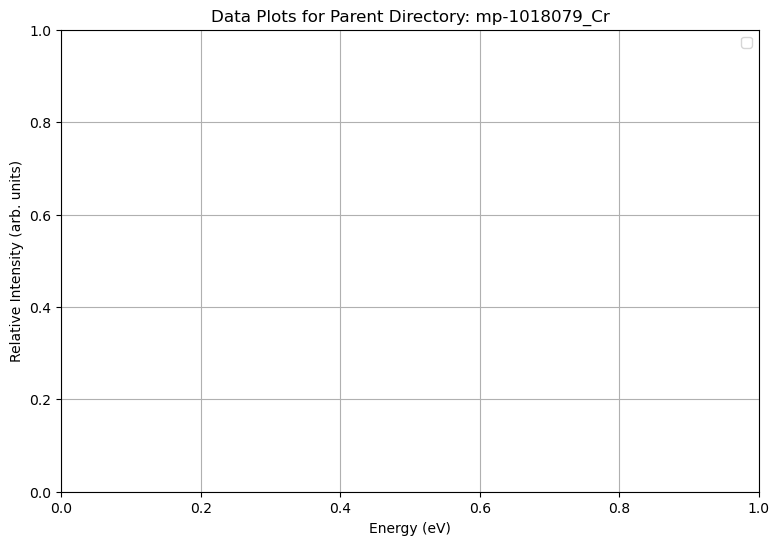

In [ ]:
matching_files = [file for file in matching_files if '_Cr' in str(Path(file).parent.name)]

# Limit to the first 20 matching files
limited_files = matching_files[:20]

file_groups = defaultdict(list)

for file in limited_files:
    # Extract the second-to-last directory (parent directory)
    parent_dir = Path(file).parent.name
    file_groups[parent_dir].append(file)

# Plot each group of files on the same plot
for parent_dir, files in file_groups.items():
    plt.figure(figsize=(9, 6))
    
    # Plot data for each file in the group
    for file in files:
        # Read the file into a DataFrame
        try:
            data = pd.read_csv(file, sep= r'\s+', header= None, skipinitialspace= True)
            data.columns = ['Energy', 'x_polarization', 'y_polarization', 'z_polarization', 'Isotropic']
            print('This is the data I am seeing from reading the file into a Pandas Dataframe: ', file)
            print('These are the column names: ', data.columns)
            print(data.head())
            print(data['x_polarization'].head())
            print(data.shape)
            for i, col in data.items():
                print(col())
                avg_value = (col['x_polarization'] + col['y_polarization'] + col['z_polarization']) / 3  # Average of columns 2, 3, and 4
                if avg_value != col['Isotropic']:
                    print(f"For row {i}, this is the sum of the columns: ", sum(col['x_polarization']))
                    print(f"For row {i}, this is the average of columns x_polarization,  y_polarization, and z_polarization", avg_value)
                    print(f"For row {i}, This is the value of column Isotropic ", col['Isotropic'])
                    raise ValueError("The isotropic value in column 5 of the Corvus.cfg.xes.out does not equal the average of the values in columns 2, 3, and 4")
                
            if data.shape[1] >= 5:  # Ensure enough columns are present for plotting
                plt.plot(data['Energy'], data['x_polarization'], label='x polarization')  # X-axis as the zeroth column
                plt.plot(data['Energy'], data['y_polarization'], label='y polarization')  # X-axis as the zeroth column
                plt.plot(data['Energy'], data['z_polarization'], label='z polarization')  # X-axis as the zeroth column
                plt.plot(data['Energy'], data['Isotropic'], label='Isotropic')  # X-axis as the zeroth column
            else:
                print(f'File {file} does not have enough columns to plot all combinations.')
        except Exception as e:
            print(f"Error reading {file}: {e}")

    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    
    plt.xlabel('Energy (eV)')
    plt.ylabel('Relative Intensity (arb. units)')
    plt.title(f'Data Plots for Parent Directory: {parent_dir}')
    plt.legend(loc='best')
    plt.grid(True)
    
    plt.show()

### 2. Choose the best anisotropy and isotropy candidates for the job
##### (Open project: determine an algorithm to quantify anisotropy and give the user best possible candidates)

In [ ]:
###EXPECTED ANISOTROPY###

#input only the name of the material from the .cif file.
#ex: if you calculated FeO.cif, just input 'FeO' in the list.
anistropic_materials_name = ['', '']

anisotropic_matching_files = []
for aniso_material in anistropic_materials_name:
    for metal in transition_metals:
        
        # Use glob to search for files of the anisotropy material name, and the transition metal appears after the underscore
        pattern = f'{parent_dir}**/{aniso_material}_{metal}/Corvus.cfavg.xes.out'
        anistropic_materials_name.extend(glob.glob(pattern, recursive=True))
    
print(f'These are the matching_files list: {anisotropic_matching_files}')

###EXPECTED ISOTROPY###
isotropic_materials_name = ['', '']

isotropic_matching_files = []
for iso_material in isotropic_materials_name:
    for metal in transition_metals:
        
        # Use glob to search for files where the transition metal appears after the underscore
        pattern = f'{parent_dir}**/{iso_material}_{metal}/Corvus.cfavg.xes.out'
        isotropic_materials_name.extend(glob.glob(pattern, recursive=True))

print(f'These are the matching_files list: {isotropic_matching_files}')

### 3. Do some math and check if it makes sense

In [ ]:
def xes_integrated_abs_difference(data_1, data_2):
    ''' 
    Calculate the integrated absolute difference of Δμ(E) for data_1 and data_2.

    Data 1 and 2 have orthogonal polarizations.

    Parameters:
    data_1 (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization 1.
    data_2 (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization 2.

    Returns:
    difference (float): The integrated absolute difference of Δμ(E) between the two datasets.
    '''
    # Calculate the absolute difference of Delta mu(E)
    abs_difference = np.abs(data_1 - data_2)

    # Integrate the absolute difference over the energy range
    integrated_abs_difference = np.sum(abs_difference)

    return integrated_abs_difference

aniso_integrated_diff = xes_integrated_abs_difference()


In [ ]:
def xes_average(data_1, data_2, data_3):
    '''
    Calculates the integral of the average of 3 orthogonally polarized XES spectra.

    Parameters:
    data_1 (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization 1.
    data_2 (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization 2.
    data_3 (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization 3.

    Return:
    integrated_average (float): The integral of the average of the 3 spectra.
    '''
    # Calculate the average of Delta mu(E) values
    average_delta_muE = (data_1 + data_2 + data_3) / 3

    # Integrate the average Delta mu(E) over the energy range
    integrated_average = np.sum(average_delta_muE)

    return integrated_average



In [ ]:
def anisotropy_parameter(xes_difference, xes_average):
    '''
    Calculate the anisotropy parameter, which is the quotient of the XES difference and the XES average.

    Parameters:
    xes_difference (float): The integrated absolute difference of Δμ(E).
    xes_average (float): The integral of the average of the 3 spectra.

    Returns:
    float: The anisotropy parameter.
    '''
    if xes_average == 0:
        raise ValueError(
            "The xes_average must not be zero to avoid division by zero.")

    return xes_difference / xes_average


In [ ]:

def anisotropy_matrix(data_x, data_y, data_z):
    '''
    Calculate a 3x3 anisotropy matrix where each entry represents the anisotropy parameter 
    for the difference between two datasets divided by the average of all three datasets.

    Parameters:
    data_x (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization x.
    data_y (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization y.
    data_z (pandas.DataFrame): The DataFrame containing the X-ray absorption data for polarization z.

    Returns:
    numpy.ndarray: A 3x3 anisotropy matrix.
    '''
    # Calculate the XES average of all three datasets
    xes_avg = xes_average(data_x, data_y, data_z)

    # Initialize a 3x3 matrix
    anisotropy_mat = np.zeros((3, 3))

    # Define the pairs for which to calculate the differences
    pairs = [(data_x, data_y), (data_x, data_z), (data_y, data_z)]

    # Fill the anisotropy matrix with the anisotropy parameters
    for i, (data1, data2) in enumerate(pairs):
        diff = xes_integrated_abs_difference(data1, data2)
        anisotropy_mat[i][(i+1) % 3] = anisotropy_parameter(diff, xes_avg)
        anisotropy_mat[(i+1) % 3][i] = anisotropy_mat[i][(i+1) %
                                                         3]  # Symmetric entries

    return anisotropy_mat

In [ ]:
def read_data(file):
    return np.loadtxt(file)

output_txt = f'{parent_dir}anisotropy_data.csv'

# Open the CSV file for writing
with open(output_txt, mode='w', newline='') as file_out:
    txt_writer = csv.writer(file_out, delimiter= '\t')
    
    # Write the header row
    txt_writer.writerow(['parent_dir', 'm00', 'm01', 'm02', 'm10', 'm11', 'm12', 'm20', 'm21', 'm22'])
    
    # Loop through each matching file and process the data
    for file in matching_files:
        data = read_data(file)
        data_x = data[:, 1]
        data_y = data[:, 2]
        data_z = data[:, 3]
        
        # Calculate the anisotropy matrix (3x3)
        anisotropy_mat = anisotropy_matrix(data_x, data_y, data_z)
        
        # Get the parent directory name
        parent_dir = os.path.basename(os.path.dirname(file))
        
        # Flatten the 3x3 matrix into a single row (list)
        flattened_matrix = anisotropy_mat.flatten().tolist()
        
        # Prepend the parent_dir to the flattened matrix row
        row = [parent_dir] + flattened_matrix
        
        # Write the row to the CSV
        txt_writer.writerow(row)

print(f"Data has been written to {output_txt}")
    

NameError: name 'anisotropy_matrix' is not defined

# (WIP) PROBABILITY DISTRIBUTION PARAMETER GUESSER
##### Perhaps some deconvolution data science can be in order?

In [18]:
def LORENTZIAN_MODEL(center, num, sigma= 0.15, amp= 4000):
    """We know we want to set up lots of Lorentzians. Here is a function that sets one up fast.
    The function will stay in all caps unlike regular functions because I'm too lazy to change it after the
    first time I wrote this. This will be filled with data at the bottom of the cell"""

    model = LorentzianModel(prefix= num)
    modelparams = model.make_params()
    modelparams[num + 'center'].set(center)
    modelparams[num + 'amplitude'].set(amp)
    modelparams[num + 'sigma'].set(sigma, min=0)
    return model, modelparams

def central_limit_theorem_slope_change(independent_column, dependent_column)->list:
    """This takes two columns of data (Corvus.cfavg.out, XMU.dat, or any other spectral data in two columns)
    and conducts the central limit theorem. We store the zero points and put them in a list for our model guesser."""
    
    zipped_data = list(zip(independent_column, dependent_column))
    
    slope_changes = []
    
    for i in range(1, len(zipped_data) - 1):
        x1, y1 = zipped_data[i-1]  
        x2, y2 = zipped_data[i]    
        x3, y3 = zipped_data[i+1]
        
        slope1 = (y2 - y1) / (x2 - x1) if (x2 - x1) != 0 else 0
        slope2 = (y3 - y2) / (x3 - x2) if (x3 - x2) != 0 else 0
        

        if slope1 > 0 and slope2 < 0:
            slope_changes.append(x2)  # store the point where the change occurs. We only want the x (eV). If you want both poits, insert (x2,y2) instead
    
    return slope_changes

#BigModel= QuadraticModel(label= 'Background')
#AllParams= BigModel.make_params(a=0, b=0, c=0)

for file in matching_files:
    data = read_data(file)
    energy = data[:, 0]
    data_x = data[:, 1]
    data_y = data[:, 2]
    data_z = data[:, 3]
    data_isotropic = data[:, 4]

slope_changes_x_pol = central_limit_theorem_slope_change(data[:, 0],data[:, 1])
#slope_changes_y_pol = central_limit_theorem_slope_change(data[: 0],data[: 2])
#slope_changes_z_pol = central_limit_theorem_slope_change(data[: 0],data[: 3])
#slope_changes_isotropic = central_limit_theorem_slope_change(data[: 0],data[: 4])

print(slope_changes_x_pol)
AllParams = None
BigModel = []

for i, cen in enumerate(slope_changes_x_pol):
    model, modelparams = LORENTZIAN_MODEL(cen, 'data%d_' % (i+1) )
    AllParams = None
    BigModel = model
    AllParams.update(modelparams)

calculation = BigModel.eval(AllParams, x= data_x)
calculation_fit = BigModel.fit(data[:, 0], AllParams, x= data_x)
calculationVariables = calculation_fit.eval_components()

print(calculation_fit.fit_report(min_correl=0.5))

plt.plot(energy, data_x, label = 'X Polarization')
plt.plot(energy, calculation_fit.best_fit, label='best fit')
for name, comp in calculationVariables.items():
    plt.plot(data[:, 0], comp, '--', label=name)
plt.legend()
plt.title('Lines of best fit')
plt.xlabel('Energy (eV)')
plt.ylabel('Relative Intensity (arb. units)')
plt.show()
myfig = plt.figure(figsize=(12,9)) 

[9640.727281687898, 9647.727281687796, 9659.327281687627]


AttributeError: 'NoneType' object has no attribute 'update'